## Problem 1

### 1c

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge
from sklearn.metrics import (
    confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score,
    roc_curve, auc, mean_squared_error, r2_score
)
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import matplotlib.pyplot as plt

In [6]:
X_b = np.array([[1,1],[0,1],[1,0],[0,0]])
Y_b = np.array([2,1,1,2])
lam = 1

theta_star = np.linalg.inv(X_b.T @ X_b + lam * np.eye(2)) @ X_b.T @ Y_b

np.random.seed(42)
N  = 1000
Xi = np.random.uniform(-2, 2, N)
ei = np.random.normal(0, np.sqrt(2), N)
Yi = 1 + 2*Xi + ei

X_sim = Xi.reshape(-1, 1)

print("Ridge Regression with varying lambda")
print(f"{'Model':<15} {'Slope':>10} {'Intercept':>10} {'MSE':>10} {'R²':>10}")

models_to_run = [
    (0,     'OLS (λ=0)'),
    (1,     'λ=1'),
    (10,    'λ=10'),
    (100,   'λ=100'),
    (1000,  'λ=1000'),
    (10000, 'λ=10000'),
]

slopes     = []
mses       = []
r2s        = []
labels     = []

for lam, label in models_to_run:
    if lam == 0:
        m = LinearRegression()
    else:
        m = Ridge(alpha=lam)

    m.fit(X_sim, Yi)
    yp        = m.predict(X_sim)
    slope     = m.coef_[0]
    intercept = m.intercept_
    mse       = mean_squared_error(Yi, yp)
    r2        = r2_score(Yi, yp)

    print(f"{label:<15} {slope:>10.3f} {intercept:>10.3f} {mse:>10.3f} {r2:>10.3f}")

    slopes.append(slope)
    mses.append(mse)
    r2s.append(r2)
    labels.append(label)

print(f"\nTrue slope = 2.0, True intercept = 1.0")

Ridge Regression with varying lambda
Model                Slope  Intercept        MSE         R²
OLS (λ=0)            1.945      1.138      1.950      0.726
λ=1                  1.944      1.138      1.950      0.726
λ=10                 1.931      1.137      1.950      0.726
λ=100                1.812      1.133      1.974      0.722
λ=1000               1.122      1.106      2.874      0.596
λ=10000              0.234      1.071      5.947      0.164

True slope = 2.0, True intercept = 1.0


As lambda gets larger, the slope keeps shrinking toward zero, moving further away from the true value of 2. The model fits the data worse, with MSE rising and R squared dropping. Small lambda barely changes anything compared to ordinary least squares, but at very high lambda the model is basically useless and loses almost all of its ability to capture the real relationship in the data.

## Problem 2

### 2a

In [11]:
df = pd.read_csv('flights.csv')

bool_cols = df.select_dtypes(include='object').columns
df[bool_cols] = df[bool_cols].apply(
    lambda c: (c.str.strip().str.upper() == 'TRUE').astype(int)
)

X = df.drop(columns=['ARRIVAL_DELAY']).values
y = df['ARRIVAL_DELAY'].values

In [13]:
# split data 75/25
np.random.seed(42)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

# normalize
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)

In [15]:
# train logistic regression model and use random seed 42
np.random.seed(42)
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train_s, y_train)
y_pred = model.predict(X_test_s)

In [19]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

print("Test set statistics")

print(f"\nConfusion Matrix:\n{confusion_matrix(y_test, y_pred)}")
print(f"\nTP={tp}  FP={fp}  TN={tn}  FN={fn}")
print(f"\nAccuracy = {accuracy_score(y_test, y_pred):.3f}")
print(f"Error     = {1 - accuracy_score(y_test, y_pred):.3f}")
print(f"\nPrecision = {precision_score(y_test, y_pred):.3f}")
print(f"Recall    = {recall_score(y_test, y_pred):.3f}")
print(f"F1 Score  = {f1_score(y_test, y_pred):.3f}")


Test set statistics

Confusion Matrix:
[[707 544]
 [505 744]]

TP=744  FP=544  TN=707  FN=505

Accuracy = 0.580
Error     = 0.420

Precision = 0.578
Recall    = 0.596
F1 Score  = 0.587


## 2b

In [30]:
feat_names = df.drop(columns=['ARRIVAL_DELAY']).columns
coef_df = pd.DataFrame({
    'feature': feat_names,
    'coefficient': model.coef_[0]
}).sort_values('coefficient', ascending=False)

print("\nAll feature coefficients:")
print(coef_df.to_string(index=False))

print("\nMost impactful feature overall:")
most_impactful = coef_df.reindex(
    coef_df['coefficient'].abs().sort_values(ascending=False).index
).iloc[0]
print(f"  {most_impactful['feature']}: {most_impactful['coefficient']:.4f}")

print("\nTop 3 positively correlated with delay:")
print(coef_df.head(3).to_string(index=False))

print("\nTop 3 negatively correlated with delay:")
print(coef_df.tail(3).to_string(index=False))


All feature coefficients:
                feature  coefficient
    SCHEDULED_DEPARTURE     0.437035
DESTINATION_AIRPORT_WRG     0.197158
     ORIGIN_AIRPORT_CWA     0.152991
DESTINATION_AIRPORT_ISP     0.152417
             AIRLINE_WN     0.141560
     ORIGIN_AIRPORT_CHA     0.138980
     ORIGIN_AIRPORT_PSC     0.136451
     ORIGIN_AIRPORT_ASE     0.133009
DESTINATION_AIRPORT_SMX     0.132924
DESTINATION_AIRPORT_LGA     0.131837
             AIRLINE_EV     0.131400
DESTINATION_AIRPORT_ACY     0.131010
DESTINATION_AIRPORT_BIL     0.128321
DESTINATION_AIRPORT_BQN     0.119100
     ORIGIN_AIRPORT_LSE     0.114991
DESTINATION_AIRPORT_BQK     0.108667
     ORIGIN_AIRPORT_OAJ     0.106900
     ORIGIN_AIRPORT_ACT     0.105580
     ORIGIN_AIRPORT_RST     0.103488
     ORIGIN_AIRPORT_ORH     0.102965
             AIRLINE_UA     0.100768
DESTINATION_AIRPORT_SCE     0.097738
     ORIGIN_AIRPORT_BJI     0.097215
     ORIGIN_AIRPORT_TOL     0.095082
     ORIGIN_AIRPORT_GRK     0.094589
     ORIGIN

## 2c

In [51]:
probs = model.predict_proba(X_test_s)[:, 1]

print("Varying decision threshold")

print(f"\n{'Threshold':<10} {'Accuracy':>10} {'Precision':>10} {'Recall':>10}")
for T in [0.25, 0.5, 0.75, 0.9]:
    yp = (probs >= T).astype(int)
    print(f"{T:<10} "
          f"{accuracy_score(y_test, yp):>10.3f} "
          f"{precision_score(y_test, yp, zero_division=0):>10.3f} "
          f"{recall_score(y_test, yp, zero_division=0):>10.3f}")

Varying decision threshold

Threshold    Accuracy  Precision     Recall
0.25            0.528      0.515      0.955
0.5             0.580      0.578      0.596
0.75            0.515      0.597      0.091
0.9             0.505      0.650      0.021


At a low threshold like 0.25, the model flags almost everything as delayed so recall is really high but precision tanks since it is getting a lot of false alarms. As you raise the threshold to 0.5, values balance out a bit more and as you go even higher to 0.75 or 0.9, the model becomes very picky. It is barely predicting any delays at all so recall crashes to almost nothing, but precision goes up. The lower thresholds catch more delays but have more false alarms, while the higher thresholds miss most delays but is more confident when it flags one.

## Problem 3

In [54]:
def addIntercept(X):
    return np.hstack([np.ones((X.shape[0], 1)), X])

def normalizeTrainTest(X_train, X_test):
    mean = np.mean(X_train, axis=0)
    std  = np.std(X_train, axis=0)
    std[std == 0] = 1
    return (X_train - mean) / std, (X_test - mean) / std

def sigmoid(z):
    return 1 / (1 + np.exp(-np.clip(z, -500, 500)))

def crossEntropyLoss(Y_true, Y_pred):
    Y_pred = np.clip(Y_pred, 1e-15, 1 - 1e-15)
    return -np.mean(Y_true * np.log(Y_pred) + (1 - Y_true) * np.log(1 - Y_pred))

def gradientDescentLogistic(X_train, Y_train, alpha, num_iters):
    m     = X_train.shape[0]
    theta = np.zeros((X_train.shape[1], 1))
    loss_history = []

    for i in range(num_iters):
        Y_pred = sigmoid(X_train @ theta)

        gradient = (1/m) * (X_train.T @ (Y_pred - Y_train))
        theta    = theta - alpha * gradient

        loss_history.append(crossEntropyLoss(Y_train, Y_pred))

    return theta, loss_history

def gradientDescentLogisticCheckpoints(X_train, Y_train, alpha, max_iters, checkpoints):
    theta       = np.zeros((X_train.shape[1], 1))
    saved_thetas = {}

    for i in range(1, max_iters + 1):
        Y_pred   = sigmoid(X_train @ theta)
        gradient = (1/X_train.shape[0]) * (X_train.T @ (Y_pred - Y_train))
        theta    = theta - alpha * gradient

        if i in checkpoints:
            saved_thetas[i] = theta.copy()

    return saved_thetas

In [62]:
X_tr_b = addIntercept(X_train_s)
X_te_b = addIntercept(X_test_s)

y_tr_col = y_train.reshape(-1, 1)
y_te_col = y_test.reshape(-1, 1)

learning_rates = [0.1, 0.01, 0.001]
checkpoints    = [10, 50, 100]

print("Cross-entropy loss objectives:")

print(f"{'LR':<10} {'Loss at 10':>10} {'Loss at 50':>10} {'Loss at 100':>10}")

for lr_val in learning_rates:
    saved = gradientDescentLogisticCheckpoints(
        X_tr_b, y_tr_col, lr_val, 100, checkpoints
    )
    losses = {}
    for itr, theta in saved.items():
        yp         = sigmoid(X_tr_b @ theta)
        losses[itr] = crossEntropyLoss(y_tr_col, yp)

    print(f"{lr_val:<10} {losses[10]:>10.3f} {losses[50]:>10.3f} {losses[100]:>10.3f}")

Cross-entropy loss objectives:
LR         Loss at 10 Loss at 50 Loss at 100
0.1             0.664      0.630      0.622
0.01            0.689      0.677      0.665
0.001           0.693      0.691      0.689


In [68]:
print("Metrics at 100 iterations")
print(f"{'LR':<10} {'Accuracy':>10} {'Precision':>10} {'Recall':>10} {'F1':>10}")

for lr_val in learning_rates:
    saved = gradientDescentLogisticCheckpoints(
        X_tr_b, y_tr_col, lr_val, 100, checkpoints
    )
    theta_100 = saved[100]
    yp_prob   = sigmoid(X_te_b @ theta_100).flatten()
    yp        = (yp_prob >= 0.5).astype(int)

    print(f"{lr_val:<10} "
          f"{accuracy_score(y_test, yp):>10.3f} "
          f"{precision_score(y_test, yp, zero_division=0):>10.3f} "
          f"{recall_score(y_test, yp, zero_division=0):>10.3f} "
          f"{f1_score(y_test, yp, zero_division=0):>10.3f}")

print("\nsklearn Logistic Regression Metrics")
print(f"{'Split':<10} {'Accuracy':>10} {'Precision':>10} {'Recall':>10} {'F1':>10}")

for split, X_sp, y_sp in [('Train', X_train_s, y_train), ('Test', X_test_s, y_test)]:
    yp = model.predict(X_sp)
    print(f"{split:<10} "
          f"{accuracy_score(y_sp, yp):>10.3f} "
          f"{precision_score(y_sp, yp):>10.3f} "
          f"{recall_score(y_sp, yp):>10.3f} "
          f"{f1_score(y_sp, yp):>10.3f}")

Metrics at 100 iterations
LR           Accuracy  Precision     Recall         F1
0.1             0.578      0.575      0.590      0.583
0.01            0.571      0.567      0.597      0.582
0.001           0.571      0.567      0.598      0.582

sklearn Logistic Regression Metrics
Split        Accuracy  Precision     Recall         F1
Train           0.648      0.644      0.650      0.647
Test            0.580      0.578      0.596      0.587


The sklearn model does noticeably better on training at 0.648 accuracy but drops to 0.580 on the test set, which suggests some overfitting. The manual logistic regression with different learning rates all lands around 0.578 on the test set which is actually pretty close to sklearn on test. So the manual implementation generalizes similarly, it just never gets as high on training which makes sense since sklearn runs until full convergence while the manual one only does 100 iterations.

## Problem 4

### 4a

In [75]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

print("kNN 5-Fold Cross Validation")
print(f"{'k':<10} {'Accuracy':>10} {'Error':>10} {'Precision':>10} {'Recall':>10} {'F1':>10}")

best_k, best_err = None, float('inf')

for k in [3, 5, 7, 21]:
    accs, precs, recs, f1s = [], [], [], []

    for train_idx, val_idx in kf.split(X_train_s):
        X_fold_tr,  X_fold_val = X_train_s[train_idx], X_train_s[val_idx]
        y_fold_tr,  y_fold_val = y_train[train_idx],   y_train[val_idx]

        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_fold_tr, y_fold_tr)
        yp = knn.predict(X_fold_val)

        accs.append(accuracy_score(y_fold_val, yp))
        precs.append(precision_score(y_fold_val, yp, zero_division=0))
        recs.append(recall_score(y_fold_val, yp, zero_division=0))
        f1s.append(f1_score(y_fold_val, yp, zero_division=0))

    avg_acc = np.mean(accs)
    avg_err = 1 - avg_acc

    print(f"{k:<10} {avg_acc:>10.3f} {avg_err:>10.3f} "
          f"{np.mean(precs):>10.3f} {np.mean(recs):>10.3f} {np.mean(f1s):>10.3f}")

    if avg_err < best_err:
        best_err, best_k = avg_err, k

print(f"\n Best k: {best_k} since it has the lowest avg cross validation error: {best_err:.3f}")


kNN 5-Fold Cross Validation
k            Accuracy      Error  Precision     Recall         F1
3               0.514      0.486      0.511      0.525      0.517
5               0.525      0.475      0.521      0.538      0.529
7               0.524      0.476      0.520      0.540      0.529
21              0.533      0.467      0.529      0.557      0.542

 Best k: 21 since it has the lowest avg cross validation error: 0.467


### 4b

In [92]:
knn_best = KNeighborsClassifier(n_neighbors=best_k)
knn_best.fit(X_train_s, y_train)

lda = LinearDiscriminantAnalysis()
lda.fit(X_train_s, y_train)


classifiers = [
    (f'kNN (k={best_k})', knn_best),
    ('Logistic Reg',      model),
    ('LDA',               lda),
]

def print_metrics(name, y_true, yp):
    acc = accuracy_score(y_true, yp)
    print(f"\n{name:<10} Accuracy={acc:.3f}  Error={1-acc:.3f}  "
          f"Precision={precision_score(y_true,yp,zero_division=0):.3f}  "
          f"Recall={recall_score(y_true,yp,zero_division=0):.3f}  "
          f"F1={f1_score(y_true,yp,zero_division=0):.3f}")

print("All 3 Classifiers Metrics")

for split_name, X_sp, y_sp in [('TRAIN', X_train_s, y_train),
                                 ('TEST',  X_test_s,  y_test)]:
    print(f"\n{split_name}")
    for name, clf in classifiers:
        print_metrics(name, y_sp, clf.predict(X_sp))

All 3 Classifiers Metrics

TRAIN

kNN (k=21) Accuracy=0.610  Error=0.390  Precision=0.603  Recall=0.628  F1=0.615

Logistic Reg Accuracy=0.648  Error=0.352  Precision=0.644  Recall=0.650  F1=0.647

LDA        Accuracy=0.649  Error=0.351  Precision=0.645  Recall=0.652  F1=0.649

TEST

kNN (k=21) Accuracy=0.520  Error=0.480  Precision=0.518  Recall=0.540  F1=0.529

Logistic Reg Accuracy=0.580  Error=0.420  Precision=0.578  Recall=0.596  F1=0.587

LDA        Accuracy=0.579  Error=0.421  Precision=0.576  Recall=0.599  F1=0.587


On training, all three models perform similarly around 0.64 to 0.65 accuracy, with LDA and logistic regression edging out kNN slightly. On the test set, kNN drops the most going from 0.610 down to 0.520, which suggests it is overfitting to the training data more than the other two. Logistic regression and LDA both hold up much better on test and end up performing almost identically. Overall logistic regression and LDA are the better models here since they generalize more consistently, while kNN struggles to maintain its training performance on unseen data.

### 4c

ROC Curves and AUC
Logistic Regression AUC = 0.606
LDA AUC = 0.607


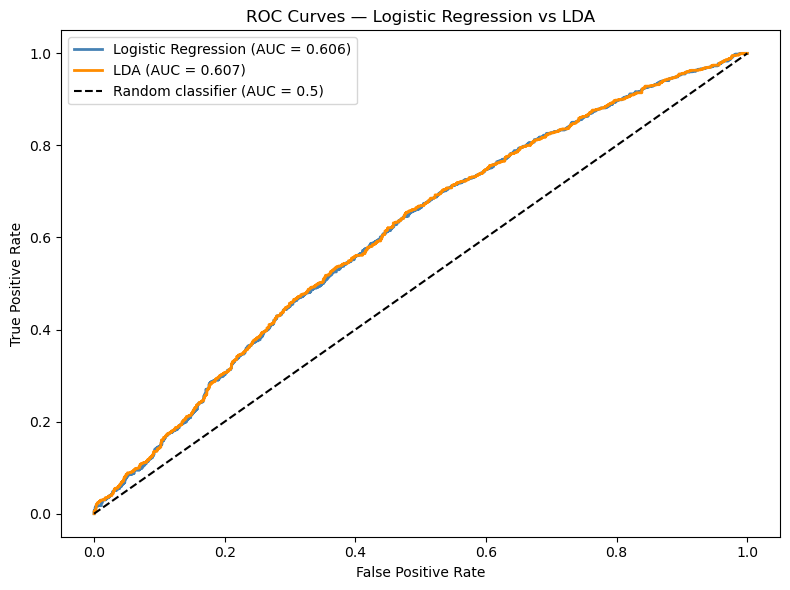

In [96]:
print("ROC Curves and AUC")

fig, ax = plt.subplots(figsize=(8, 6))

for name, clf, color in [('Logistic Regression', model, 'steelblue'),
                          ('LDA',                 lda,   'darkorange')]:
    probs        = clf.predict_proba(X_test_s)[:, 1]
    fpr, tpr, _  = roc_curve(y_test, probs)
    roc_auc      = auc(fpr, tpr)
    print(f"{name} AUC = {roc_auc:.3f}")
    ax.plot(fpr, tpr, color=color, lw=2,
            label=f'{name} (AUC = {roc_auc:.3f})')

ax.plot([0, 1], [0, 1], 'k--', label='Random classifier (AUC = 0.5)')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curves — Logistic Regression vs LDA')
ax.legend()
plt.tight_layout()
plt.show()

### 4d

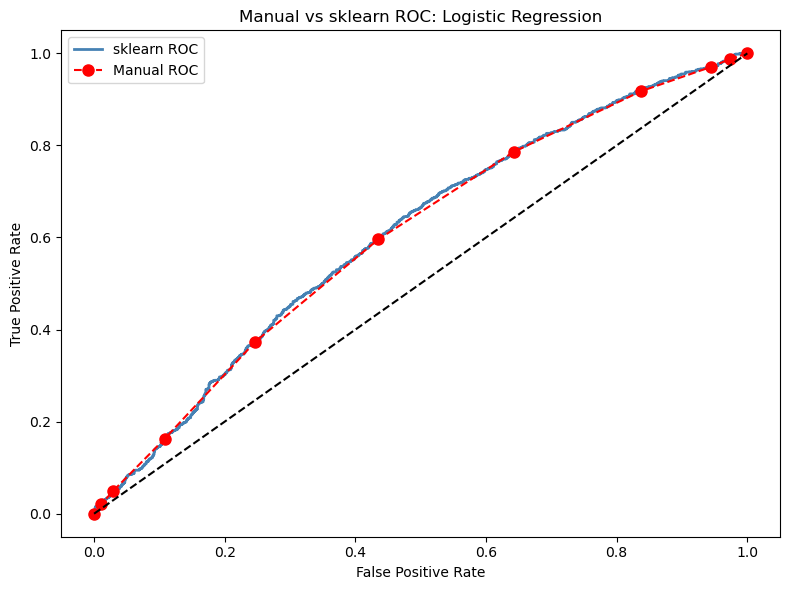

In [101]:
probs_lr = model.predict_proba(X_test_s)[:, 1]

manual_fpr, manual_tpr = [], []
for T in [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
    yp               = (probs_lr >= T).astype(int)
    tn, fp, fn, tp_v = confusion_matrix(y_test, yp, labels=[0, 1]).ravel()
    fpr_val          = fp / (fp + tn) if (fp + tn) > 0 else 0
    tpr_val          = tp_v / (tp_v + fn) if (tp_v + fn) > 0 else 0
    manual_fpr.append(fpr_val)
    manual_tpr.append(tpr_val)

fpr_sk, tpr_sk, _ = roc_curve(y_test, probs_lr)

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(fpr_sk,     tpr_sk,     'steelblue',  lw=2,       label='sklearn ROC')
ax.plot(manual_fpr, manual_tpr, 'ro--', markersize=8,     label='Manual ROC')
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Manual vs sklearn ROC: Logistic Regression')
ax.legend()
plt.tight_layout()
plt.show()

The manual ROC curve looks rougher and less smooth than the sklearn one because its only using 11 thresholds so you get 11 points on the curve. Sklearn uses every unique predicted probability as a threshold so it gets hundreds of points and produces a much smoother curve. To make them more similar, I would need to add more thresholds to the manual version so it has more data points to plot, which will smoothen its curve.

### Problem 5

### 5a

In [106]:
X_all = df.drop(columns=['ARRIVAL_DELAY']).values
y_all = df['ARRIVAL_DELAY'].values

In [108]:
def my_kfold_cv(X, y, ModelClass, model_kwargs, k):
    n = len(y)

    rng = np.random.RandomState(42)
    shuffled_idx = rng.permutation(n)

    folds = np.array_split(shuffled_idx, k)

    val_errors = []

    for i in range(k):
        val_idx   = folds[i]
        train_idx = np.concatenate([folds[j] for j in range(k) if j != i])

        X_tr,  X_val = X[train_idx], X[val_idx]
        y_tr,  y_val = y[train_idx], y[val_idx]

        sc      = StandardScaler()
        X_tr_s  = sc.fit_transform(X_tr)
        X_val_s = sc.transform(X_val)

        model = ModelClass(**model_kwargs)
        model.fit(X_tr_s, y_tr)

        yp    = model.predict(X_val_s)
        err   = 1 - accuracy_score(y_val, yp)
        val_errors.append(err)
        print(f"    Fold {i+1:>2}/{k}: val error = {err:.3f}")

    avg_err = np.mean(val_errors)
    print(f"Average validation error: {avg_err:.3f}")
    return avg_err


In [131]:
my_kfold_cv(X_all, y_all, LogisticRegression, {'max_iter': 1000, 'random_state': 42}, 5)
my_kfold_cv(X_all, y_all, LinearDiscriminantAnalysis, {}, 5);

    Fold  1/5: val error = 0.412
    Fold  2/5: val error = 0.404
    Fold  3/5: val error = 0.404
    Fold  4/5: val error = 0.405
    Fold  5/5: val error = 0.421
Average validation error: 0.409
    Fold  1/5: val error = 0.414
    Fold  2/5: val error = 0.404
    Fold  3/5: val error = 0.409
    Fold  4/5: val error = 0.407
    Fold  5/5: val error = 0.421
Average validation error: 0.411


### 5b

In [133]:
results = {}

for k in [5, 10]:
    print(f"K = {k} Folds")

    print(f"\n  Logistic Regression (K={k}):")
    err_lr = my_kfold_cv(
        X_all, y_all,
        LogisticRegression,
        {'max_iter': 1000, 'random_state': 42},
        k
    )

    print(f"\n  LDA (K={k}):")
    err_lda = my_kfold_cv(
        X_all, y_all,
        LinearDiscriminantAnalysis,
        {},
        k
    )

    results[k] = {'Logistic Regression': err_lr, 'LDA': err_lda}

K = 5 Folds

  Logistic Regression (K=5):
    Fold  1/5: val error = 0.412
    Fold  2/5: val error = 0.404
    Fold  3/5: val error = 0.404
    Fold  4/5: val error = 0.405
    Fold  5/5: val error = 0.421
Average validation error: 0.409

  LDA (K=5):
    Fold  1/5: val error = 0.414
    Fold  2/5: val error = 0.404
    Fold  3/5: val error = 0.409
    Fold  4/5: val error = 0.407
    Fold  5/5: val error = 0.421
Average validation error: 0.411
K = 10 Folds

  Logistic Regression (K=10):
    Fold  1/10: val error = 0.417
    Fold  2/10: val error = 0.426
    Fold  3/10: val error = 0.403
    Fold  4/10: val error = 0.394
    Fold  5/10: val error = 0.413
    Fold  6/10: val error = 0.399
    Fold  7/10: val error = 0.409
    Fold  8/10: val error = 0.404
    Fold  9/10: val error = 0.425
    Fold 10/10: val error = 0.431
Average validation error: 0.412

  LDA (K=10):
    Fold  1/10: val error = 0.414
    Fold  2/10: val error = 0.423
    Fold  3/10: val error = 0.405
    Fold  4/10: v

### 5c

Logistic regression and LDA perform almost identically across both k=5 and k=10, with average validation errors all hovering around 0.41. LDA is slightly better or the same in most cases. Going from k=5 to k=10 barely changes anything either since the errors stay consistent. This means the models are stable and the results are not sensitive to how you split the data. Overall neither model clearly wins, but LDA edges out logistic regression by a tiny margin.